In [1]:
import os
import sys

%matplotlib inline
import pandas as pd
import cvxportfolio as cp
import quandl
import numpy as np
import pickle
from scipy.stats import qmc

In [7]:
quandl.ApiConfig.api_key = 'XB2H55DxdNiJjBbLvCzu'

In [8]:
tickers = ['AMZN', 'GOOGL', 'TSLA', 'NKE']
start_date='2012-01-01'
end_date='2016-12-31'
returns = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Close'].pct_change())
                for ticker in tickers]))
returns[["USDOLLAR"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/(250*100)
returns = returns.fillna(method='ffill').iloc[1:]

returns.tail()

,AMZN,GOOGL,TSLA,NKE,USDOLLAR
Date,,,,,
2016-12-23,-0.007503,-0.002322,0.023459,-0.004411,0.000020
2016-12-27,0.014213,0.002637,0.029015,-0.011944,0.000020
2016-12-28,0.000946,-0.006618,0.000957,-0.005264,0.000021
2016-12-29,-0.009040,-0.002101,-0.023027,0.000784,0.000018
2016-12-30,-0.019970,-0.012991,-0.004612,-0.004505,0.000020


In [9]:
r_hat = returns.rolling(window=250, min_periods=250).mean().shift(1).dropna()
Sigma_hat = returns.rolling(window=250, min_periods=250, closed='neither').cov().dropna().droplevel(1)

r_hat.tail()

,AMZN,GOOGL,TSLA,NKE,USDOLLAR
Date,,,,,
2016-12-23,0.000683,0.000219,-0.000074,-0.000660,0.000012
2016-12-27,0.000542,0.000150,-0.000124,-0.000706,0.000013
2016-12-28,0.000627,0.000179,-0.000023,-0.000691,0.000013
2016-12-29,0.000707,0.000215,-0.000052,-0.000664,0.000013
2016-12-30,0.000901,0.000302,0.000133,-0.000598,0.000013


In [10]:
# Dimensions are [risk_aversion, trade_aversion, holding_cost, bid_ask_spread, borrow_cost]
# array([5.0005e+02, 6.7500e+00, 5.0050e+01, 5.0500e-03, 5.5000e-04])

In [116]:
params = scaled_samples[546]
params

array([7.49951172e+00, 2.67334961e+01, 1.09667969e-04, 2.74902344e-04])

In [139]:
# risk_aversion = params[0]
# trade_aversion = params[1]
# holding_cost = params[2]
# bid_ask_spread = params[3]
# borrow_cost = params[4]

risk_aversion = 1
trade_aversion = params[0]
holding_cost = params[1]
bid_ask_spread = params[2] * 15
borrow_cost = params[3]

In [140]:
# Context parameters
tcost_model=cp.TcostModel(half_spread=0.5 * bid_ask_spread)
hcost_model=cp.HcostModel(borrow_costs=borrow_cost)

risk_model = cp.FullSigma(Sigma_hat)
# Action parameters
leverage_limit = cp.LeverageLimit(3)

spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[risk_aversion*risk_model, trade_aversion*tcost_model, holding_cost*hcost_model],
                                constraints=[leverage_limit])

market_sim=cp.MarketSimulator(returns, [tcost_model, hcost_model], cash_key='USDOLLAR') 
init_portfolio = pd.Series(index=returns.columns, data=250000.)
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(init_portfolio,
                               start_time='2013-01-03',  end_time='2016-12-31',  
                               policies=[spo_policy, cp.Hold()])
results[0].summary()

Number of periods                              1007
Initial timestamp               2013-01-03 00:00:00
Final timestamp                 2016-12-30 00:00:00
Portfolio return (%)                         36.423
Excess return (%)                            36.307
Excess risk (%)                              34.069
Sharpe ratio                                  1.066
Max. drawdown                                33.700
Turnover (%)                                  4.382
Average policy time (sec)                     0.038
Average simulator time (sec)                  0.004


In [29]:
results[0].returns.mean() * 100

0.6794021163594256

<AxesSubplot:>

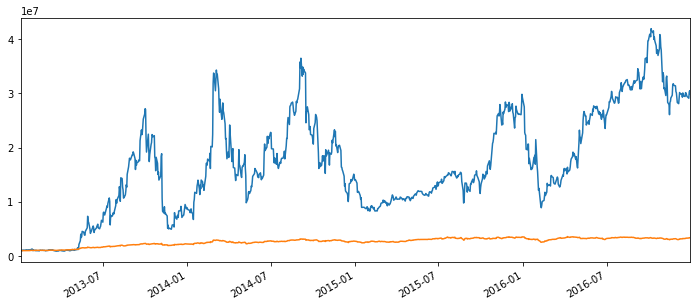

In [30]:
results[0].v.plot(figsize=(12,5))
results[1].v.plot(figsize=(12,5))

<AxesSubplot:>

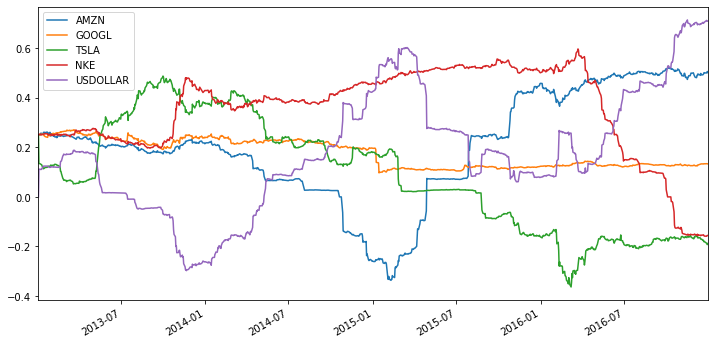

In [8]:
results[0].w.plot(figsize=(12,6))

In [24]:
# Dimensions are [risk_aversion, trade_aversion, holding_cost, bid_ask_spread, borrow_cost]

In [16]:
sampler = qmc.Sobol(d=5, scramble=False)

In [20]:
sample = sampler.random(3000)

In [21]:
sample

array([[0.14978027, 0.49499512, 0.98132324, 0.30310059, 0.51550293],
       [0.64978027, 0.99499512, 0.48132324, 0.80310059, 0.01550293],
       [0.89978027, 0.24499512, 0.73132324, 0.05310059, 0.26550293],
       ...,
       [0.85559082, 0.89660645, 0.95080566, 0.62902832, 0.70910645],
       [0.60559082, 0.14660645, 0.20080566, 0.37902832, 0.95910645],
       [0.10559082, 0.64660645, 0.70080566, 0.87902832, 0.45910645]])

In [55]:
np.mean(sample, axis=0)

array([0.49980359, 0.50002421, 0.49963668, 0.50001103, 0.50038188])

In [41]:
lowers = [0.1, 5.5, 0.1, 1e-04, 1e-04]
uppers = [1000, 8, 100, 1e-02, 1e-03]

In [42]:
scaled_sample = qmc.scale(sample, lowers, uppers)

array([[5.00050000e+02, 6.75000000e+00, 5.00500000e+01, 5.05000000e-03,
        5.50000000e-04],
       [7.50025000e+02, 6.12500000e+00, 2.50750000e+01, 2.57500000e-03,
        7.75000000e-04],
       [2.50075000e+02, 7.37500000e+00, 7.50250000e+01, 7.52500000e-03,
        3.25000000e-04],
       ...,
       [7.12675220e+02, 5.87658691e+00, 5.20743408e+01, 7.38723145e-03,
        8.03344727e-04],
       [2.12725220e+02, 7.12658691e+00, 2.12434082e+00, 2.43723145e-03,
        3.53344727e-04],
       [1.50231470e+02, 6.34533691e+00, 5.83180908e+01, 4.29348145e-03,
        9.72094727e-04]])

In [56]:
def extract_results(result):
    portfolio_return = result.returns.mean() * 100 * result.PPY
    excess_return = result.excess_returns.mean() * 100 * result.PPY
    excess_risk = result.excess_returns.std() * 100 * np.sqrt(result.PPY)
    sharpe_ratio = result.sharpe_ratio
    max_drawdown = result.max_drawdown
    return [portfolio_return, excess_return, excess_risk, sharpe_ratio, max_drawdown]

In [57]:
extract_results(results[0])

[72.05850593104746,
 71.94323722329396,
 76.5321877167474,
 0.940506512708237,
 70.10326331796388]

In [14]:
import os

In [15]:
os.chdir('../../')

In [16]:
os.getcwd()

'/home/sebtsh/fast-drbo'

In [17]:
scaled_samples = pickle.load(open('data/portfolio/scaled_samples.p','rb'))

In [18]:
all_results = pickle.load(open('data/portfolio/all_results.p','rb'))

In [19]:
import matplotlib.pyplot as plt

(array([348., 333., 328., 326., 301., 206., 159., 124.,  92.,  70.,  69.,
         47.,  44.,  37.,  29.,  30.,  35.,  36.,  25.,  12.,   9.,  10.,
         15.,  18.,  18.,  19.,  13.,  14.,  14.,  13.,  10.,   5.,  11.,
          7.,  10.,   3.,   4.,   4.,  12.,   7.,   6.,  10.,   9.,   9.,
          5.,   5.,   6.,   6.,   3.,   5.,   3.,   2.,   9.,   4.,   2.,
          2.,   3.,   4.,   4.,   2.,   5.,  27.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

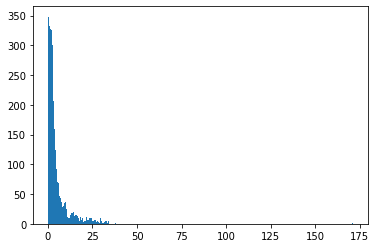

In [20]:
plt.hist(all_results[:, 0], bins='auto')

In [21]:
all_results[:, 0]

array([171.20933332,   2.79293346,   0.92357702, ...,   1.63869376,
         2.45430878,   3.33066261])

In [22]:
scaled_samples[0]

array([1.0e-01, 5.5e+00, 1.0e-01, 1.0e-04, 1.0e-04])

In [23]:
scaled_samples[1]

array([5.0005e+02, 6.7500e+00, 5.0050e+01, 5.0500e-03, 5.5000e-04])

In [25]:
! pip install scikit-learn

     |████████████████████████████████| 22.3 MB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 60.5 MB/s eta 0:00:01


In [26]:
from sklearn.neighbors import NearestNeighbors

In [27]:
neigh = NearestNeighbors(n_neighbors=5)

In [48]:
neigh.fit(scaled_samples[:, 0:1])

NearestNeighbors()

In [50]:
neigh.kneighbors(scaled_samples[0, 0:1][None, :])

(array([[0.        , 0.48823242, 0.73234863, 0.97646484, 1.46469727]]),
 array([[   0, 2047, 2048, 1023, 1024]]))

In [31]:
scaled_samples[1663]

array([1.03528809e+01, 6.84887695e+00, 3.56333008e+00, 1.46801758e-03,
       5.56591797e-04])

In [34]:
all_results[1663]

array([27.62332236, 27.50805365, 18.69949163,  1.47179059, 17.58753614])

In [35]:
all_results[2304]

array([34.32134688, 34.20607817, 28.86735179,  1.18552932, 27.90240818])

In [36]:
all_results[1535]

array([34.32134758, 34.20607888, 28.86735299,  1.18552929, 27.90240968])

In [37]:
all_results[896]

array([34.32134527, 34.20607656, 28.86734948,  1.18552936, 27.90240453])

In [38]:
scaled_samples[2304]

array([6.69113770e+00, 5.96691895e+00, 8.85588379e+00, 9.56252441e-03,
       6.28442383e-04])

In [40]:
scaled_samples[1535]

array([3.51762695e+00, 7.69604492e+00, 1.02948730e+01, 6.44702148e-03,
       8.45751953e-04])

In [41]:
scaled_samples[896]

array([8.88818359e+00, 6.54248047e+00, 7.41689453e+00, 5.33037109e-03,
       4.01464844e-04])

In [32]:
scaled_samples[0]

array([1.0e-01, 5.5e+00, 1.0e-01, 1.0e-04, 1.0e-04])

(array([199., 200., 201., 200., 199., 201., 200., 198., 201., 199., 202.,
        199., 200., 200., 201.]),
 array([1.00000000e-01, 6.67437256e+01, 1.33387451e+02, 2.00031177e+02,
        2.66674902e+02, 3.33318628e+02, 3.99962354e+02, 4.66606079e+02,
        5.33249805e+02, 5.99893530e+02, 6.66537256e+02, 7.33180981e+02,
        7.99824707e+02, 8.66468433e+02, 9.33112158e+02, 9.99755884e+02]),
 <BarContainer object of 15 artists>)

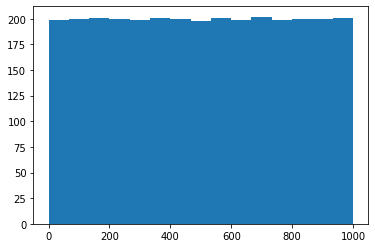

In [47]:
plt.hist(scaled_samples[:, 0], bins='auto')

In [54]:
scaled_samples[2047]

array([5.88232422e-01, 7.06860352e+00, 9.31221191e+01, 3.57563477e-03,
       6.67333984e-04])

In [55]:
all_results[2047]

array([34.32135627, 34.20608757, 28.86736373,  1.18552915, 27.9024204 ])

In [108]:
all_results = pickle.load(open("data/portfolio/all_results.p",'rb'))

In [141]:
np.histogram(all_results[:, 3], bins=20)

(array([  42,   16,   16,   37,   58,   26,   16,   21,   13,   12,    9,
           4,    9,    6,    7,    3,   16,   21,   42, 1674]),
 array([0.84697728, 0.86408173, 0.88118619, 0.89829065, 0.9153951 ,
        0.93249956, 0.94960402, 0.96670848, 0.98381293, 1.00091739,
        1.01802185, 1.0351263 , 1.05223076, 1.06933522, 1.08643967,
        1.10354413, 1.12064859, 1.13775305, 1.1548575 , 1.17196196,
        1.18906642]))

In [110]:
np.argmax(all_results[:, 0])

546

In [111]:
all_results[546]

array([94.5556518 , 94.44038309, 80.42359918,  1.17487103, 64.74917225])

In [113]:
sampler = qmc.Sobol(d=4, scramble=False)
sample = sampler.random(2048)
lowers = [5.5, 0.1, 1e-04, 1e-04]
uppers = [8, 100, 1e-02, 1e-03]
scaled_samples = qmc.scale(sample, lowers, uppers)

In [115]:
scaled_samples[546]

array([7.49951172e+00, 2.67334961e+01, 1.09667969e-04, 2.74902344e-04])

In [121]:
np.argmin(all_results[:, 0])

537

In [122]:
scaled_samples[537]

array([7.14794922e+00, 9.07319336e+01, 9.85498047e-03, 6.82714844e-04])